# Certamen 2: Machine Learning for Business Intelligence.

**Integrante:** Daniel Moreno Cartagena

**Profesor:** Rodrigo De La Fuente

## Instrucciones

1. Este certamen es de caracter individual, por lo tanto queda estrictamente prohibida la copia de codigo ajeno. **Cualquier copia será motivo de reprobación (esto excluye código mostrado en laboratorios prácticos).**

2. En caso de elaborar su respuesta **basandose** en código ajeno encontrado en la web, debe agradecer al menos citando la referencia.

3. La fecha límite para la entrega de este certamen queda establecida para el **22/08/2020 a la media noche**.

Nota: La resolución de algunos de los ejercicios puede tomar bastante tiempo, así como su ejecución. Por lo tanto se recomienda hacer la tarea con anticipación y evitar riesgos. Además, es **obligatorio el uso de Google Colab**.

## Pregunta 1: Convolutional Generative Adversarial Nets (CGAN).

En esta sección, se pide reproducir el modelo [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets) (Goodfellow I., et al. 2014), utilizando redes convolucionales. Para esto se utilizará el dataset Fashion MNIST, que consiste en prendas de ropa en blanco y negro.

1.1 Cargue los datos utilizando la ayuda de su [https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data](documentación). Muestre al menos 1 imagen de cada clase, pertenecientes al conjunto de entrenamiento (2 ptos). 

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

from keras.initializers import RandomNormal
from keras.models import Sequential
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras import losses, optimizers
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Conv2DTranspose, Reshape, BatchNormalization, Concatenate, Dropout

from keras.datasets.fashion_mnist import load_data

In [ ]:
#Se cargan los datos
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


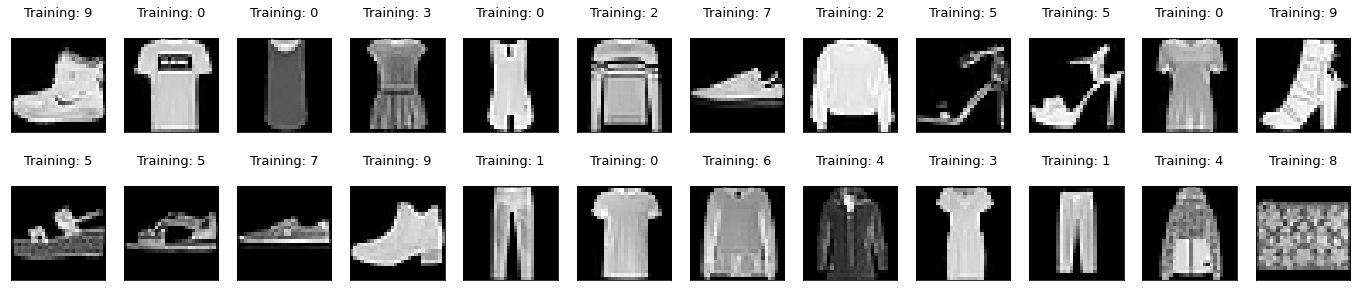

In [ ]:
#Se muestra al menos una imagen de las clases del conjunto de entrenamiento
fig = plt.figure(figsize=(24,5))
i=0
for i, (image, label) in enumerate(zip(x_train[0:24], y_train[0:24])):
  ax = plt.subplot(2, 12, i + 1)
  plt.imshow(np.reshape(image, (28,28)), cmap='gray')
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  plt.title('Training: %i\n' % label, fontsize = 13)

1.2 En clases se vieron ciertas técnicas para mejorar el entrenamiento de los modelos generativos adversarios [(ref)](https://arxiv.org/abs/1606.03498). Dentro de ellas estaba la normalización de los datos entre [-1,1]. Normalice el conjunto de entrenamiento entre ese rango. Además, añada una dimensión extra que permita el uso de redes convolucionales 2D (como se vio en clases) (3 ptos).

In [ ]:
#Normalización entre [-1,1]
x_train =  x_train.astype('float32')/255
x_train = x_train*2 - 1
print(x_train.max(),x_train.min())

1.0 -1.0


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
#Se añade dimensión extra
x_train = np.expand_dims(x_train, axis=3)
x_train.shape

(60000, 28, 28, 1)

1.3 Construya una arquitectura convolucional que permita el entrenamiento del modelo (generador y discriminador), siguiendo los consejos vistos en clases (ej. batch normalization, leaky relu). Para este paso, es posible utilizar como base la arquitectura encoder-decoder vista en clase práctica (sin embargo, debe tener en cuenta que esa arquitectura recibe como input una imagen de (1, 32, 32), por lo cual sería necesario redimensionar las imágenes del conjunto de entrenamiento previamente) (5 ptos).

In [ ]:
latent_dim = 100 #Hiperparámetro de la pregunta 1.4

#Generador
generator = Sequential()
generator.add(Dense(7*7*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=latent_dim))
generator.add(LeakyReLU(alpha=0.2))    
generator.add(Reshape((7, 7, 256)))
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2D(1, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       524416    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 128)       0

In [ ]:
#Discriminador
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3), input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid", input_shape=[28, 28, 1]))

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

1.4 Entrene el modelo generativo adversario utilizando optimizador Adam y los siguientes hiperparámetros (5 ptos):
- learning_rate=0.0002
- beta_1=0.5
- latent_dim=100
- num_epochs=1000.

1.5 Muestre imágenes generadas en la epoca 10, 100, 500 y 1000 (5 ptos).


In [ ]:
### Las imagenes de las epocas 10, 100, 500 y 1000 de la pregunta 1.5 se iran mostrando durante el entrenamiento. ###

In [ ]:
#Hiperparámetros
learning_rate = 0.0002
beta_1 = 0.5
num_epochs = 1000
batch_size = 32
noise_shape = 100
n_classes = 10
steps_per_epoch = 10 

In [ ]:
GAN = Sequential([generator,discriminator])
adam = keras.optimizers.Adam(learning_rate, beta_1)

discriminator.compile(optimizer=adam ,loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

GAN.compile(optimizer=adam ,loss='binary_crossentropy')
GAN.layers
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         2054785   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 2,267,650
Trainable params: 2,054,785
Non-trainable params: 212,865
_________________________________________________________________


In [ ]:
y_train = keras.utils.to_categorical(y_train, num_classes=n_classes)

Currently on Epoch 1
Discriminator loss: 0.519, Generator loss: 0.710
Currently on Epoch 2
Discriminator loss: 0.472, Generator loss: 0.595
Currently on Epoch 3
Discriminator loss: 0.533, Generator loss: 0.522
Currently on Epoch 4
Discriminator loss: 0.443, Generator loss: 0.673
Currently on Epoch 5
Discriminator loss: 0.441, Generator loss: 0.823
Currently on Epoch 6
Discriminator loss: 0.478, Generator loss: 0.977
Currently on Epoch 7
Discriminator loss: 1.056, Generator loss: 0.490
Currently on Epoch 8
Discriminator loss: 0.600, Generator loss: 1.370
Currently on Epoch 9
Discriminator loss: 0.525, Generator loss: 1.153
Currently on Epoch 10
Discriminator loss: 0.751, Generator loss: 0.692


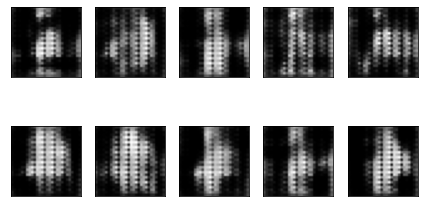

Currently on Epoch 11
Discriminator loss: 0.440, Generator loss: 1.368
Currently on Epoch 12
Discriminator loss: 0.748, Generator loss: 0.650
Currently on Epoch 13
Discriminator loss: 0.573, Generator loss: 0.964
Currently on Epoch 14
Discriminator loss: 0.674, Generator loss: 0.757
Currently on Epoch 15
Discriminator loss: 0.626, Generator loss: 0.907
Currently on Epoch 16
Discriminator loss: 0.654, Generator loss: 0.772
Currently on Epoch 17
Discriminator loss: 0.657, Generator loss: 0.875
Currently on Epoch 18
Discriminator loss: 0.657, Generator loss: 0.948
Currently on Epoch 19
Discriminator loss: 0.702, Generator loss: 0.798
Currently on Epoch 20
Discriminator loss: 0.645, Generator loss: 0.729
Currently on Epoch 21
Discriminator loss: 0.662, Generator loss: 0.855
Currently on Epoch 22
Discriminator loss: 0.670, Generator loss: 0.916
Currently on Epoch 23
Discriminator loss: 0.653, Generator loss: 0.964
Currently on Epoch 24
Discriminator loss: 0.642, Generator loss: 0.754
Curren

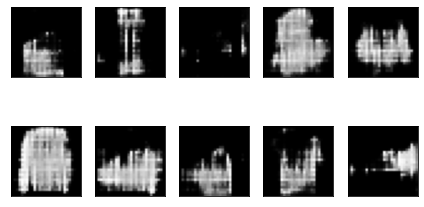

Currently on Epoch 101
Discriminator loss: 0.656, Generator loss: 0.772
Currently on Epoch 102
Discriminator loss: 0.659, Generator loss: 0.884
Currently on Epoch 103
Discriminator loss: 0.676, Generator loss: 0.817
Currently on Epoch 104
Discriminator loss: 0.662, Generator loss: 0.818
Currently on Epoch 105
Discriminator loss: 0.643, Generator loss: 0.794
Currently on Epoch 106
Discriminator loss: 0.653, Generator loss: 0.879
Currently on Epoch 107
Discriminator loss: 0.672, Generator loss: 0.743
Currently on Epoch 108
Discriminator loss: 0.672, Generator loss: 0.773
Currently on Epoch 109
Discriminator loss: 0.646, Generator loss: 0.800
Currently on Epoch 110
Discriminator loss: 0.623, Generator loss: 0.870
Currently on Epoch 111
Discriminator loss: 0.645, Generator loss: 0.863
Currently on Epoch 112
Discriminator loss: 0.669, Generator loss: 0.833
Currently on Epoch 113
Discriminator loss: 0.626, Generator loss: 0.828
Currently on Epoch 114
Discriminator loss: 0.643, Generator loss

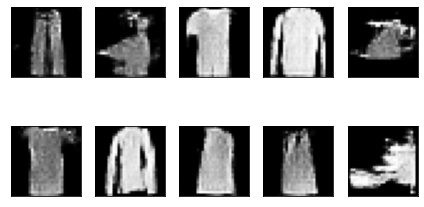

Currently on Epoch 501
Discriminator loss: 0.611, Generator loss: 0.777
Currently on Epoch 502
Discriminator loss: 0.665, Generator loss: 0.845
Currently on Epoch 503
Discriminator loss: 0.712, Generator loss: 0.739
Currently on Epoch 504
Discriminator loss: 0.665, Generator loss: 0.806
Currently on Epoch 505
Discriminator loss: 0.694, Generator loss: 0.799
Currently on Epoch 506
Discriminator loss: 0.695, Generator loss: 0.766
Currently on Epoch 507
Discriminator loss: 0.655, Generator loss: 0.769
Currently on Epoch 508
Discriminator loss: 0.675, Generator loss: 0.827
Currently on Epoch 509
Discriminator loss: 0.690, Generator loss: 0.834
Currently on Epoch 510
Discriminator loss: 0.694, Generator loss: 0.805
Currently on Epoch 511
Discriminator loss: 0.657, Generator loss: 0.792
Currently on Epoch 512
Discriminator loss: 0.645, Generator loss: 0.837
Currently on Epoch 513
Discriminator loss: 0.627, Generator loss: 0.831
Currently on Epoch 514
Discriminator loss: 0.683, Generator loss

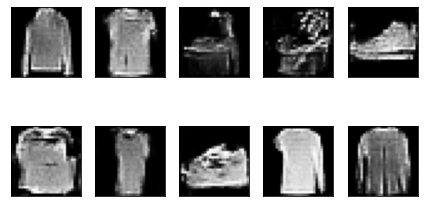

Training is complete


In [ ]:
#https://www.kaggle.com/sayakdasgupta/introduction-to-gans-on-fashion-mnist-dataset

#Entrenamiento del modelo
gen_losses = []
disc_losses = []

for epoch in range(num_epochs):
    print(f"Currently on Epoch {epoch+1}")
    for i in range(steps_per_epoch):           
        noise = np.random.normal(0, 1, (batch_size, latent_dim))       
        fake_imgs = generator.predict_on_batch(noise)
        imgs = x_train[i*batch_size:(i+1)*batch_size]
       
        #training discriminator on real images
        true_labels=np.ones((batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(imgs, true_labels)
        
        #training discriminator on fake images
        fake_labels=np.zeros((batch_size,1))
        d_loss_fake=discriminator.train_on_batch(fake_imgs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #training generator 
        noise=np.random.normal(0, 1, (batch_size, latent_dim))
        discriminator.trainable = False 
        g_loss =GAN.train_on_batch(noise, true_labels)  
    
    print('Discriminator loss: {:.3f}, Generator loss: {:.3f}'.format(d_loss[0], g_loss))
    gen_losses.append(g_loss)
    disc_losses.append(d_loss[0])

    #Muestra las imagenes generadas en las epocas 10, 100, 500 y 1000
    if epoch==9 or epoch==99 or epoch==499 or epoch==999:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))
        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.show()
print('Training is complete')  

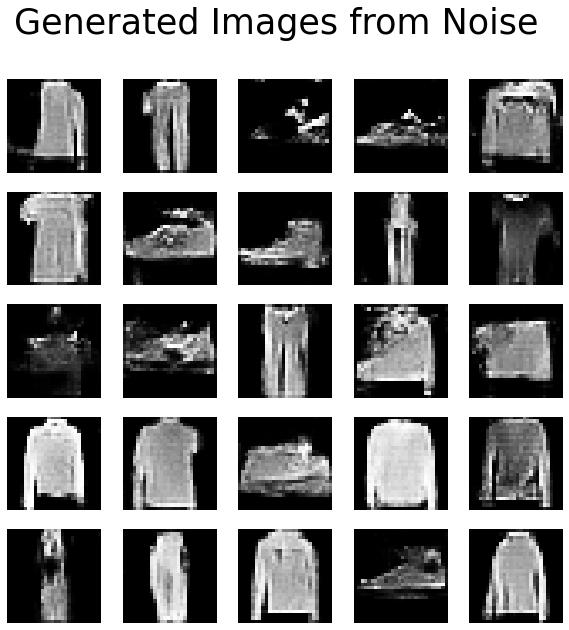

In [ ]:
#Generador de imagenes desde noise
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = generator.predict(noise)

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(r, c, figsize=(10,10))
fig.suptitle('Generated Images from Noise', fontsize = 35)

ix = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[ix].reshape(28,28), cmap='gray')
        axs[i,j].axis('off')
        ix += 1
plt.show()

## Pregunta 2: Recurrent Neural Networks (RNN)

Imagine que llega a su nuevo trabajo, el cuál obtuvo luego de una muy buena entrevista en la que deleitó a su actual jefe con sus conocimientos de Deep Learning. A su sorpresa, llega uno de sus colegas y le comienza a decir que estan trabajando en un sistema de pronósticos del precio de acciones transadas en la Bolsa de Santiago, pero que hasta el momento no han podido utilizar algo mas complejo que un MLP. Le explican que ellos sólo desfasan los valores de apertura de las acciones por unos cuantos días (usted vió su código y son 5 días exáctamente), tratando de imitar el concepto de autocorrelación propio de las series de tiempo. 

Como usted quiere demostrar su valía como nueva contratación les pide que le pasen información histórica de cuatro acciones: Enel Americas, Copec, CMPC, y Engie Energía. También les dice que usted generará un modelo integrado que recibe información histórica de las 4 series y predice al mismo tiempo los 4 valores para el día siguiente. Además, como su emoción es tan grande, se compromete en comparar sus resultados con el modelo que ellos tienen implementado. 

Adicionalmente, ellos le comentan que les interesaría que los modelo sean entrenado en los que terminan el 12/29/2017, y que el set de testeo comience el día inmediatamente siguiente. Además, usted recuerda que k-fold Cross Validation no funciona para las series de tiempo, por lo que debe utilizar Walk-Forward validation para entrenar su modelo y elegir los mejores hiper-parámetros. Finalmente, le enviaron un correo que contiene el archivo aquiVanLosDatosCompadre.zip


###Preparación de la data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy

from numpy import nan
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.optimizers import Adam

from numpy import array
from numpy import hstack
from keras.layers import Dense

from tensorflow import keras
from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive/') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
data_ecl = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Certamen 2/ECL.csv', sep=',', parse_dates=True, low_memory=False, header=None)
data_cmpc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Certamen 2/CMPC.csv', sep=',', parse_dates=True, low_memory=False, header=None)
data_copec = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Certamen 2/COPEC.csv', sep=',', parse_dates=True, low_memory=False)
data_enelam = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Certamen 2/ENELAM.csv', sep=',', parse_dates=True, low_memory=False, header=None)

In [ ]:
print(data_ecl.head())
print(data_cmpc.head())
print(data_copec.head())
print(data_enelam.head())

            0           1
0  2009-01-02  486.000000
1  2009-01-05  469.890015
2  2009-01-06  490.000000
3  2009-01-07  505.000000
4  2009-01-08  515.000000
            0           1
0  2009-01-02  835.809998
1  2009-01-05  894.817017
2  2009-01-06  869.492004
3  2009-01-07  958.130005
4  2009-01-08  945.466980
         Date    High          Low  ...        Close     Volume    Adj Close
0  2009-01-02  5190.0  4805.000000  ...  5091.200195  5408482.0  4678.071289
1  2009-01-05  5150.0  4748.299805  ...  5149.000000   748469.0  4731.181641
2  2009-01-06  5350.0  5149.000000  ...  5337.100098   331189.0  4904.017090
3  2009-01-07  5300.0  5160.000000  ...  5198.899902   166214.0  4777.030762
4  2009-01-08  5250.0  5109.000000  ...  5250.000000   118183.0  4823.985840

[5 rows x 7 columns]
            0          1
0  2009-01-02  97.938004
1  2009-01-05  97.873199
2  2009-01-06  97.932098
3  2009-01-07  97.932098
4  2009-01-08  96.516296


In [ ]:
data_ecl.columns = ['Date', 'Open']
data_cmpc.columns = ['Date', 'Open']
data_enelam.columns = ['Date', 'Open']

In [ ]:
#Division de la data de entrenamiento y testeo
ecl_train = data_ecl[data_ecl['Date']<='2017-12-29'].copy()
cmpc_train = data_cmpc[data_ecl['Date']<='2017-12-29'].copy()
copec_train = data_copec[data_ecl['Date']<='2017-12-29'].copy()
enelam_train = data_enelam[data_ecl['Date']<='2017-12-29'].copy()

ecl_test = data_ecl[data_ecl['Date']>'2017-12-29'].copy()
cmpc_test = data_cmpc[data_ecl['Date']>'2017-12-29'].copy()
copec_test = data_copec[data_ecl['Date']>'2017-12-29'].copy()
enelam_test = data_enelam[data_ecl['Date']>'2017-12-29'].copy()

print(ecl_train.shape)
print(cmpc_train.shape)
print(copec_train.shape)
print(enelam_train.shape)

print(ecl_test.shape)
print(cmpc_test.shape)
print(copec_test.shape)
print(enelam_test.shape)

(2246, 2)
(2246, 2)
(2246, 7)
(2246, 2)
(597, 2)
(597, 2)
(597, 7)
(597, 2)


In [ ]:
copec_train

,Date,High,Low,Open,Close,Volume,Adj Close
0,2009-01-02,5190.000000,4805.000000,4850.000000,5091.200195,5408482.0,4678.071289
1,2009-01-05,5150.000000,4748.299805,4748.299805,5149.000000,748469.0,4731.181641
2,2009-01-06,5350.000000,5149.000000,5149.000000,5337.100098,331189.0,4904.017090
3,2009-01-07,5300.000000,5160.000000,5300.000000,5198.899902,166214.0,4777.030762
4,2009-01-08,5250.000000,5109.000000,5200.000000,5250.000000,118183.0,4823.985840
...,...,...,...,...,...,...,...
2241,2017-12-22,9798.900391,9320.000000,9599.000000,9777.799805,203203.0,9687.406250
2242,2017-12-26,9800.000000,9651.000000,9777.000000,9793.900391,319563.0,9703.358398
2243,2017-12-27,9793.900391,9601.000000,9793.900391,9667.599609,235453.0,9578.225586
2244,2017-12-28,9820.000000,9667.599609,9799.000000,9774.900391,399579.0,9684.533203


In [ ]:
#Se eliman las columnas que ya no se van a ocupar
train_ecl = ecl_train.drop(['Date'], axis=1)
train_cmpc = cmpc_train.drop(['Date'], axis=1)
train_copec = copec_train.drop(['Date', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], axis=1)
train_enelam = enelam_train.drop(['Date'], axis=1)

test_ecl = ecl_test.drop(['Date'], axis=1)
test_cmpc = cmpc_test.drop(['Date'], axis=1)
test_copec = copec_test.drop(['Date', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], axis=1)
test_enelam = enelam_test.drop(['Date'], axis=1)

In [ ]:
#https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecas

# Se divide la secuencia multivariante en muestras
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# Se define la secuencia de entrada de entrenamiento y test en vector
in_seq1 = array(train_ecl)
in_seq2 = array(train_cmpc)
in_seq3 = array(train_copec)
in_seq4 = array(train_enelam)

in_test1 = array(test_ecl)
in_test2 = array(test_cmpc)
in_test3 = array(test_copec)
in_test4 = array(test_enelam)

# Se conviente la estuctura en [rows, columns]
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))

in_test1 = in_test1.reshape((len(in_test1), 1))
in_test2 = in_test2.reshape((len(in_test2), 1))
in_test3 = in_test3.reshape((len(in_test3), 1))
in_test4 = in_test4.reshape((len(in_test4), 1))

In [ ]:
# Se apilan las columnas horizontalmente
dataset_train = hstack((in_seq1, in_seq2, in_seq3, in_seq4))
dataset_test = hstack((in_test1, in_test2, in_test3, in_test4))

In [ ]:
# Se convierten en datos de entrada y salida
n_steps=5
X_train, Y_train = split_sequences(dataset_train, n_steps)
X_test, Y_test = split_sequences(dataset_test, n_steps)

In [ ]:
X_train.shape 

(2241, 5, 4)

In [ ]:
#Se ocupara en la entrada del LSTM
xlstm_train = X_train
xlstm_test = X_test

1. Implementación, selección de hyperparámetros, y entrenamiento del MLP (5 ptos).

In [ ]:
# Se aplanan los datos para ingresarlos a la red
n_input_train = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], n_input_train))
n_output_train = Y_train.shape[1]

n_input_test = X_test.shape[1] * X_test.shape[2]
X_test = X_test.reshape((X_test.shape[0], n_input_test))
n_output_test = Y_test.shape[1]

In [ ]:
#Hiperparámetros
input_dim = n_input_train
lr = 0.001
epochs = 200
batch_size = 16
n_output = n_output_train

In [ ]:
X_train.shape

(2241, 20)

In [ ]:
# Definición del modelo MLP
mlp_model = Sequential()
mlp_model.add(Dense(128, activation='relu', input_dim=input_dim))
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dense(32, activation='relu'))
mlp_model.add(Dense(n_output))
mlp_model.summary()
opt = keras.optimizers.Adam(learning_rate=lr)
mlp_model.compile(optimizer=opt, loss='mean_squared_error')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               2688      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 132       
Total params: 13,156
Trainable params: 13,156
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Entrenamiento del modelo
history = mlp_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/200
141/141 - 0s - loss: 1386421.3750
Epoch 2/200
141/141 - 0s - loss: 15596.5625
Epoch 3/200
141/141 - 0s - loss: 12419.9121
Epoch 4/200
141/141 - 0s - loss: 11041.4580
Epoch 5/200
141/141 - 0s - loss: 10359.9238
Epoch 6/200
141/141 - 0s - loss: 9273.0098
Epoch 7/200
141/141 - 0s - loss: 8930.4238
Epoch 8/200
141/141 - 0s - loss: 7983.8984
Epoch 9/200
141/141 - 0s - loss: 7832.5776
Epoch 10/200
141/141 - 0s - loss: 8040.7246
Epoch 11/200
141/141 - 0s - loss: 7881.0415
Epoch 12/200
141/141 - 0s - loss: 6979.6245
Epoch 13/200
141/141 - 0s - loss: 7139.6919
Epoch 14/200
141/141 - 0s - loss: 7499.1309
Epoch 15/200
141/141 - 0s - loss: 6449.0869
Epoch 16/200
141/141 - 0s - loss: 6377.1792
Epoch 17/200
141/141 - 0s - loss: 6223.3389
Epoch 18/200
141/141 - 0s - loss: 6392.3101
Epoch 19/200
141/141 - 0s - loss: 6349.0635
Epoch 20/200
141/141 - 0s - loss: 6548.1694
Epoch 21/200
141/141 - 0s - loss: 6511.9834
Epoch 22/200
141/141 - 0s - loss: 6245.6440
Epoch 23/200
141/141 - 0s - loss: 

2. Implementación, selección de hyperparámetros, y entrenamiento del LSTM RNN (10 ptos).

In [ ]:
#Hiperparámetros
learning_rt = 0.001
in_units = 128
num_epoch = 200
batch_sz = 16

In [ ]:
xdata_train, ydata_train = np.array(xlstm_train), np.array(Y_train)
print(xdata_train.shape, ydata_train.shape)

xdata_test, ydata_test = np.array(xlstm_test), np.array(Y_test)
print(xdata_test.shape, ydata_test.shape)

(2241, 5, 4) (2241, 4)
(592, 5, 4) (592, 4)


In [ ]:
### Building LSTM ####

In [ ]:
lstm_model = Sequential()

lstm_model.add(LSTM(units=in_units, activation='relu', return_sequences=True, input_shape=(xdata_train.shape[1], xdata_train.shape[1]-1)))
#model.add(Dropout(0.1))

lstm_model.add(LSTM(units=64, activation='relu', return_sequences=True))
#model.add(Dropout(0.1))

lstm_model.add(LSTM(units=32, activation='relu', return_sequences=True))
#model.add(Dropout(0.1))

lstm_model.add(LSTM(units=16, activation='relu'))
#model.add(Dropout(0.1))

lstm_model.add(Dense(units=4))

In [ ]:
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 128)            68096     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 64)             49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 32)             12416     
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 68        
Total params: 133,124
Trainable params: 133,124
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt1 = keras.optimizers.Adam(learning_rate=learning_rt)
lstm_model.compile(optimizer=opt1, loss = 'mean_squared_error')

In [ ]:
lstm_model.fit(xdata_train, ydata_train, batch_size = batch_sz, epochs=num_epoch, verbose=2)

Epoch 1/200
141/141 - 4s - loss: 6421972.5000
Epoch 2/200
141/141 - 4s - loss: 369259.8125
Epoch 3/200
141/141 - 4s - loss: 27538.4824
Epoch 4/200
141/141 - 4s - loss: 26823.4062
Epoch 5/200
141/141 - 4s - loss: 26586.3672
Epoch 6/200
141/141 - 4s - loss: 28286.1895
Epoch 7/200
141/141 - 4s - loss: 27819.0664
Epoch 8/200
141/141 - 4s - loss: 27673.9609
Epoch 9/200
141/141 - 4s - loss: 26272.7070
Epoch 10/200
141/141 - 4s - loss: 25434.7734
Epoch 11/200
141/141 - 4s - loss: 26128.6133
Epoch 12/200
141/141 - 4s - loss: 36469.9961
Epoch 13/200
141/141 - 4s - loss: 27127.4395
Epoch 14/200
141/141 - 4s - loss: 27371.9648
Epoch 15/200
141/141 - 4s - loss: 101423.2969
Epoch 16/200
141/141 - 4s - loss: 34632.8750
Epoch 17/200
141/141 - 4s - loss: 29030.4863
Epoch 18/200
141/141 - 4s - loss: 28134.2363
Epoch 19/200
141/141 - 5s - loss: 27161.2949
Epoch 20/200
141/141 - 5s - loss: 27620.4375
Epoch 21/200
141/141 - 4s - loss: 27119.8457
Epoch 22/200
141/141 - 4s - loss: 26890.6973
Epoch 23/200
14

3. Evaluación de métricas de desempeño durante el periodo de testeo y comparación del rendimiento de ambos modelos (5 ptos).

In [ ]:
#Visualización de la prediccion de los valores del set de entrenamiento MLP
y_pred = mlp_model.predict(X_train, verbose=0)
print('MLP Model predict:')
print(y_pred)
print('')
#Datos Reales
print('Real Values:')
print(Y_train)
print('')
#Visualización de la prediccion de los valores del set de entrenamiento LSTM
y1_pred = lstm_model.predict(xdata_train, verbose=0)
print('LSTM Model predict:')
print(y1_pred)

MLP Model predict:
[[ 480.97052  926.51495 5138.166    100.09572]
 [ 499.16443  926.6462  5196.247    105.31996]
 [ 488.46805  906.0535  5163.47     102.83406]
 ...
 [1294.0139  2039.773   9693.166    148.26949]
 [1297.517   2043.9005  9706.461    152.1816 ]
 [1294.2296  2049.351   9695.939    148.74934]]

Real Values:
[[ 518.          938.71398926 5250.           98.52210236]
 [ 523.          941.24700928 5188.           99.40699768]
 [ 515.          920.14202881 4970.           99.68430328]
 ...
 [1358.         2098.         9793.90039062  131.69500732]
 [1330.09997559 2100.         9799.          131.24200439]
 [1330.         2090.         9750.          133.86000061]]

LSTM Model predict:
[[ 500.03278  874.71277 4995.5723    75.57101]
 [ 506.06516  905.8224  5072.1284    76.78415]
 [ 528.4781   931.5668  5275.1094    79.68009]
 ...
 [1353.7345  2102.236   9857.087    150.22052]
 [1348.1536  2107.6873  9765.786    149.04475]
 [1355.8479  2106.9087  9726.432    148.56668]]


In [ ]:
# Estimación del rendimiento del modelo MLP
trainScore_m = mlp_model.evaluate(X_train, Y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_m, math.sqrt(trainScore_m)))
testScore_m = mlp_model.evaluate(X_test, Y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore_m, math.sqrt(testScore_m)))

# Estimación del rendimiento del modelo LSTM
trainScore_l = lstm_model.evaluate(xdata_train, Y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_l, math.sqrt(trainScore_l)))
testScore_l = lstm_model.evaluate(xdata_test, Y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore_l, math.sqrt(testScore_l)))

Train Score: 5304.92 MSE (72.83 RMSE)
Test Score: 21764.57 MSE (147.53 RMSE)
Train Score: 11186.79 MSE (105.77 RMSE)
Test Score: 33843.73 MSE (183.97 RMSE)


In [ ]:
# Generate predictions for training MLP
trainPredict_m = mlp_model.predict(X_train)
testPredict_m = mlp_model.predict(X_test)

In [ ]:
# Generate predictions for training LSTM
trainPredict_l = lstm_model.predict(xdata_train)
testPredict_l = lstm_model.predict(xdata_test)

In [ ]:
data_ecl = data_ecl.drop(['Date'], axis=1)
data_cmpc = data_cmpc.drop(['Date'], axis=1)
data_copec = data_copec.drop(['Date', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], axis=1)
data_enelam = data_enelam.drop(['Date'], axis=1)
dataset = hstack((data_ecl, data_cmpc, data_copec, data_enelam))

In [ ]:
dataset.shape

(2843, 4)

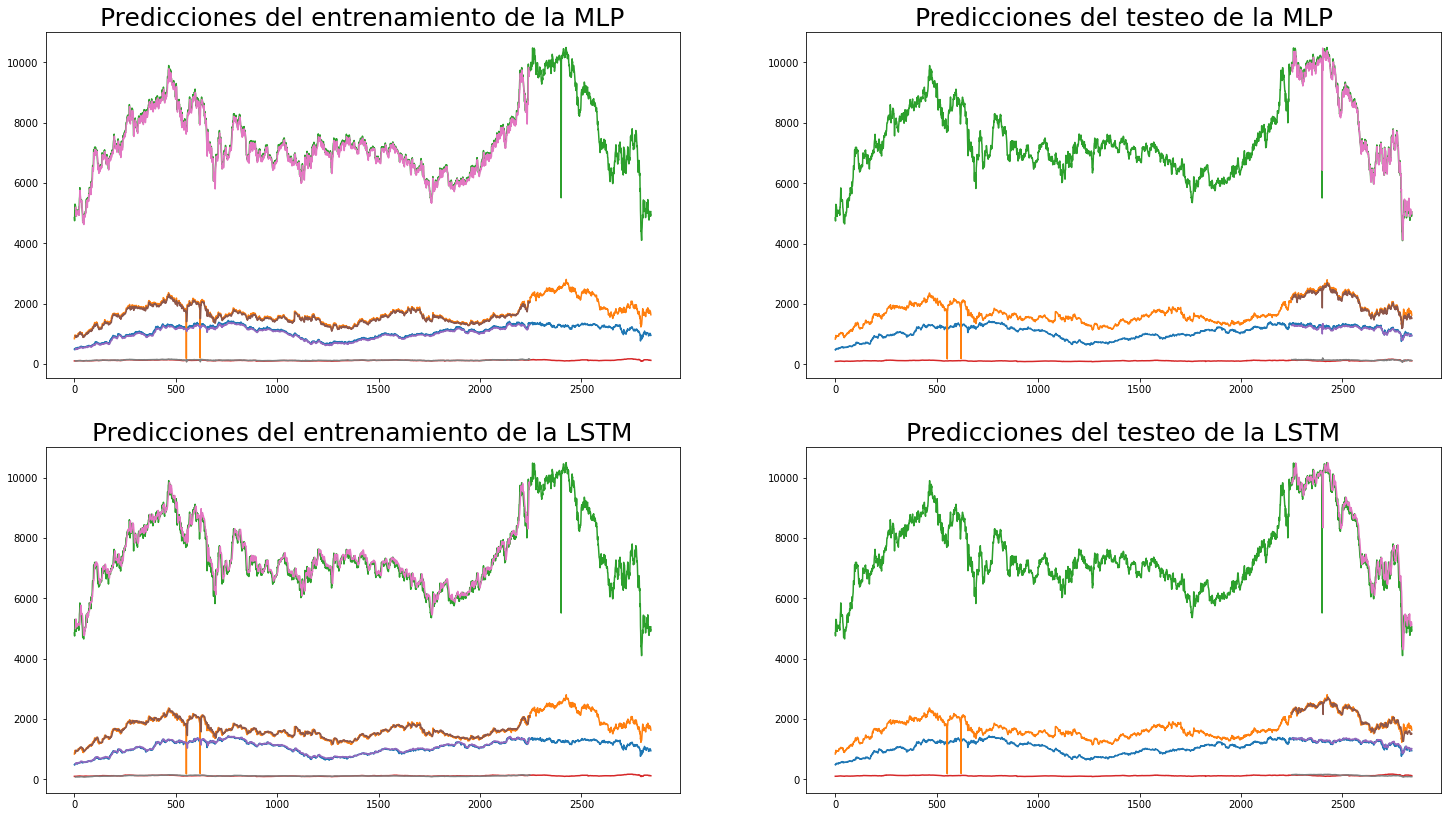

In [ ]:
#https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/

# Shift train predictions for plotting of MLP
trainPredict_mPlot = numpy.empty_like(dataset)
trainPredict_mPlot[:, :] = numpy.nan
trainPredict_mPlot[n_steps:len(trainPredict_m)+n_steps, :] = trainPredict_m

# Shift test predictions for plotting of MLP
testPredict_mPlot = numpy.empty_like(dataset)
testPredict_mPlot[:, :] = numpy.nan
testPredict_mPlot[len(trainPredict_m)+(n_steps*2):len(dataset), :] = testPredict_m

# Shift train predictions for plotting of LSTM
trainPredict_lPlot = numpy.empty_like(dataset)
trainPredict_lPlot[:, :] = numpy.nan
trainPredict_lPlot[n_steps:len(trainPredict_l)+n_steps, :] = trainPredict_l

# Shift test predictions for plotting of LSTM
testPredict_lPlot = numpy.empty_like(dataset)
testPredict_lPlot[:, :] = numpy.nan
testPredict_lPlot[len(trainPredict_l)+(n_steps*2):len(dataset), :] = testPredict_l

# Plot baseline and predictions
plt.figure(figsize=(25,14))

ax1 = plt.subplot(2, 2, 1)
plt.plot(dataset)
plt.plot(trainPredict_mPlot)
plt.title('Predicciones del entrenamiento de la MLP', fontsize=25)

ax1 = plt.subplot(2, 2, 2)
plt.plot(dataset)
plt.plot(testPredict_mPlot)
plt.title('Predicciones del testeo de la MLP', fontsize=25)

ax1 = plt.subplot(2, 2, 3)
plt.plot(dataset)
plt.plot(trainPredict_lPlot)
plt.title('Predicciones del entrenamiento de la LSTM', fontsize=25)

ax1 = plt.subplot(2, 2, 4)
plt.plot(dataset)
plt.plot(testPredict_lPlot)
plt.title('Predicciones del testeo de la LSTM', fontsize=25)

plt.show()